In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy

In [2]:
file = h5py.File('/home/raulteixeira/repos/DESC_BPZ/tests/pz_DELVEspec.h5')

data={}

for key in file.keys():
    if key=='ID':
        data['COADD_OBJECT_ID']=np.array(file[key])
    else: data[key]=np.array(file[key])

t_bpz = pd.DataFrame(data)

t_specz = pd.read_csv('/home/raulteixeira/scratch-midway2/CosmicShearData/DELVE_data_with_zspec012623.csv.gz')

data = pd.merge(t_bpz, t_specz, on='COADD_OBJECT_ID')

pz = data['Z_B'].values
specz = data['zspec'].values

In [3]:
file = h5py.File('/home/raulteixeira/repos/DESC_BPZ/tests/pz_DELVEspec_mag2123.h5')

data_zp={}

for key in file.keys():
    if key=='ID':
        data_zp['COADD_OBJECT_ID']=np.array(file[key])
    else: data_zp[key]=np.array(file[key])

t_bpz_zp = pd.DataFrame(data_zp)

t_specz_zp = pd.read_csv('/home/raulteixeira/scratch-midway2/CosmicShearData/DELVE_data_with_zspec012623.csv.gz')

data_zp = pd.merge(t_bpz_zp, t_specz_zp, on='COADD_OBJECT_ID')

pz_zp = data_zp['Z_B'].values
specz_zp = data_zp['zspec'].values

In [4]:
file = h5py.File('/home/raulteixeira/scratch-midway2/CosmicShearData/DELVE_data_with_zspec012623.h5')
photometry = {}
for i, key in enumerate(file['df/block1_items']):
    photometry[key.decode()]=np.array(file['df/block1_values'][:,i])
for i, key in enumerate(file['df/block0_items']):
    photometry[key.decode()]=np.array(file['df/block0_values'][:,i])

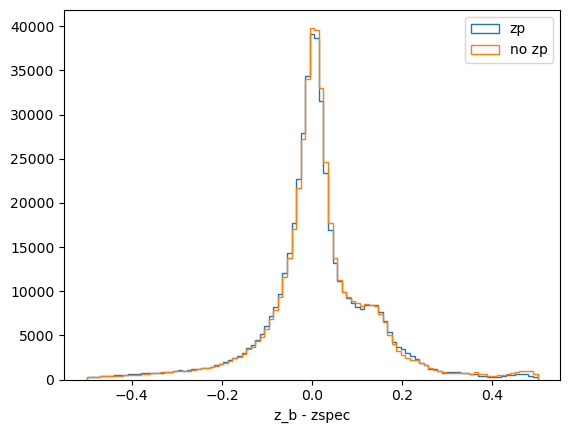

In [5]:
plt.xlabel('z_b - zspec')
plt.hist(pz_zp-specz_zp, bins=np.linspace(-.5,.5,100), histtype='step', label='zp');

plt.xlabel('z_b - zspec')
plt.hist(pz-specz, bins=np.linspace(-.5,.5,100), histtype='step', label='no zp');
plt.legend()
plt.show()

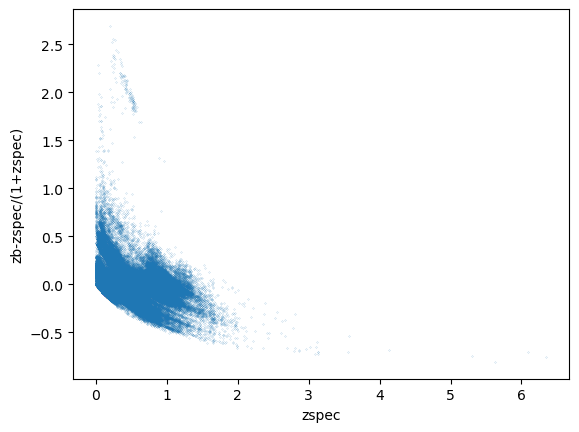

In [6]:
plt.ylabel('zb-zspec/(1+zspec)')
plt.xlabel('zspec')
plt.scatter(data['zspec'].values ,(data['Z_B'].values-data['zspec'].values)/(1+data['zspec'].values), s=.01);

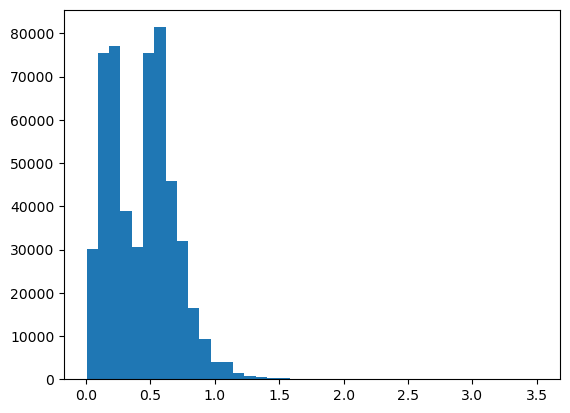

In [7]:
plt.hist(pz, bins=40);

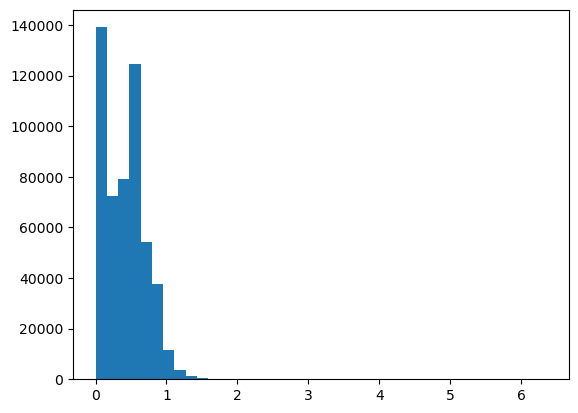

In [8]:
plt.hist(specz, bins=40);

In [9]:
from scipy.stats import gaussian_kde
xy10k = np.vstack([specz[:10000], pz[:10000]])
xy = np.vstack([specz,pz])
colors = gaussian_kde(xy10k)(xy)

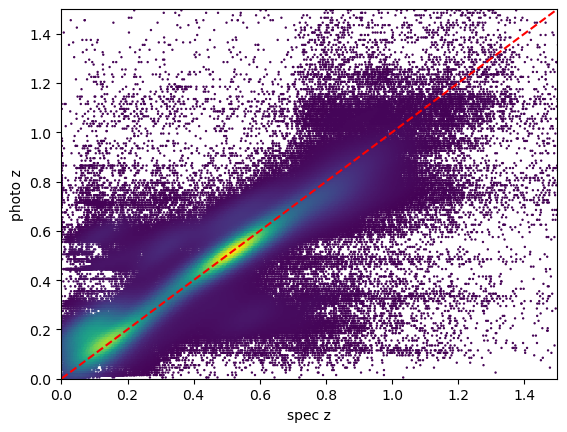

In [10]:
plt.ylabel('photo z')
plt.xlabel('spec z')
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.scatter(specz, pz, c=colors, s=.5)
plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'r--')
plt.show()

In [11]:
masks = []
for i in range(17, 24):
    masks.append(np.logical_and(i<data_zp['MAG_AUTO_I'],i+1>data_zp['MAG_AUTO_I']))

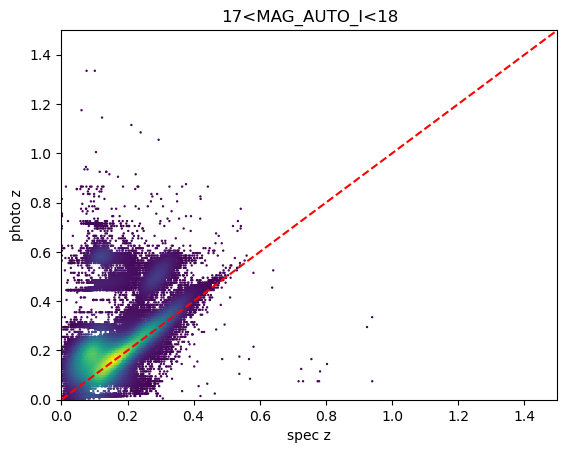

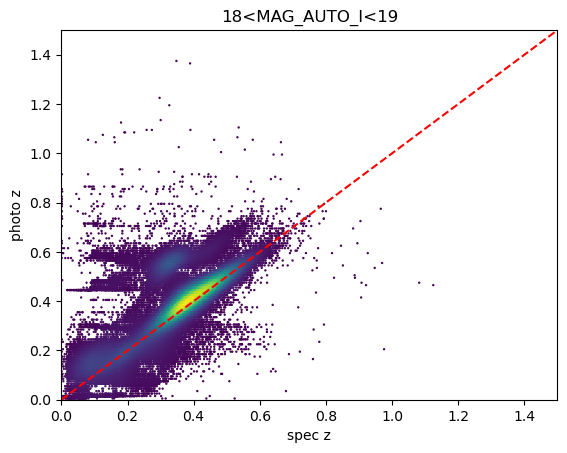

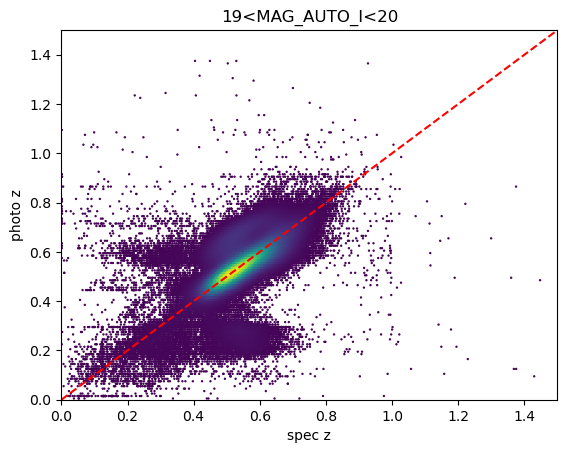

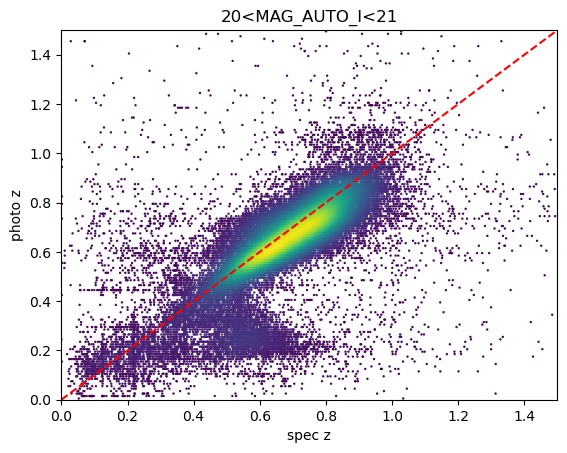

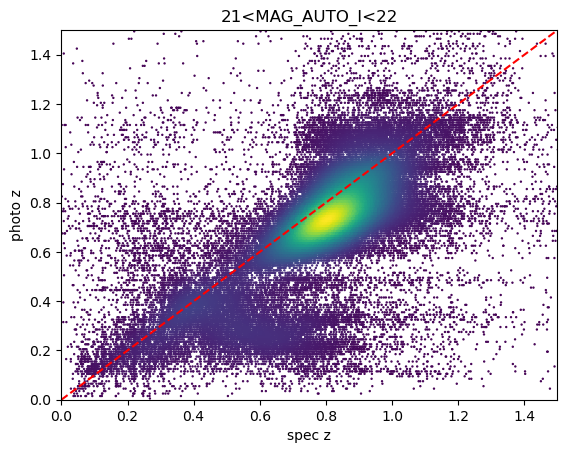

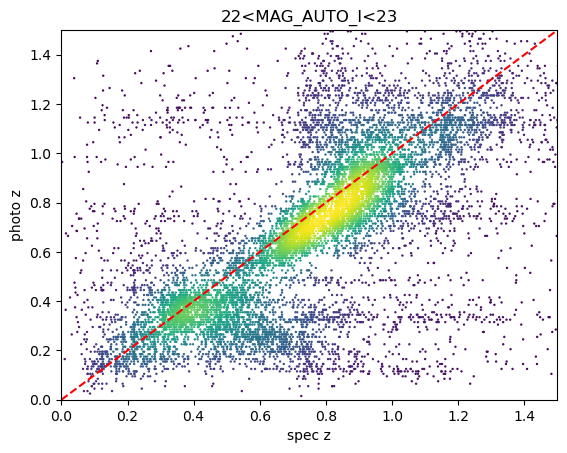

In [12]:
for i in range(0, 6):
    mask = masks[i]
    plt.ylabel('photo z')
    plt.xlabel('spec z')
    plt.title(f'{i+17}<MAG_AUTO_I<{i+18}')
    xy10k = np.vstack([specz[mask][:10000],pz[mask][:10000]])
    xy = np.vstack([specz[mask], pz[mask]])
    colors = gaussian_kde(xy10k)(xy)

    plt.xlim(0, 1.5)
    plt.ylim(0, 1.5)
    plt.scatter(specz[mask], pz[mask], c=colors, s=.5)
    plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'r--')
    plt.show()

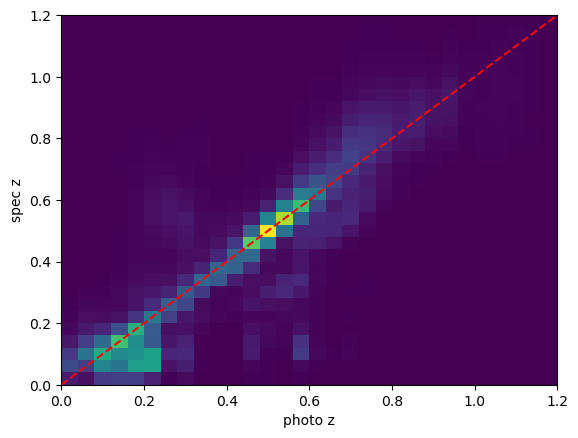

In [13]:
plt.xlabel('photo z')
plt.ylabel('spec z')
plt.hist2d(pz, specz, range=[(0, 1.2),(0, 1.2)], bins=30)
plt.plot(np.linspace(0, 1.2), np.linspace(0, 1.2), 'r--')
plt.show()

In [14]:
import numpy as np


def sigma_general(x, interval=68.0, min_samples=10):
    """
    Calculates the half-interval around the median of a distribution.

    Parameters
    ----------
    x : ndarray of shape (n, )
        Distribution samples.
    interval : float
        Interval around the median.
    min_samples : int
        Function returns nan if len(x)<min_samples
    Returns
    -------
    plow : float
        Returns p[50-interval/2]
    phigh : float
        Returns p[50+interval/2]
    sigma : float
        Returns (phigh - plow) / 2.0
    """
    msg = "Interval needs to be in range [0,100]"
    assert ((interval > 0.0) & (interval < 100.0)), msg

    intervals = [50.0 - interval / 2.0, 50.0 + interval / 2.0]
    if(len(x) > min_samples):
        plow, phigh = np.percentile(x, intervals)
        sigma = (phigh - plow) / 2.0
        return plow, phigh, sigma
    else:
        return np.ones(3)*np.nan


def magbins_sg68_OR_boostrap(dz, mag, magbins, interval=68.0, min_samples=10):
    """
    Calculates half-interval around the median of a distribution conditioned
    on a secondary quantity, and the outlier rate. The outlier rate is defined
    as the tail beyond three intervals around the median. The error is
    calculated by boostrapping subsamples.

    Parameters
    ----------
    dz : ndarray of shape (n, )
        Distribution samples.
    mag : ndarray of shape (n, )
        Secondary quantity to slice the data to compute summary statistics
        from p(dz | mag )
    magbins : ndarray of shape (nbins, )
        Bins used to slice on the secondary quantity.
    interval : float
        Interval around the median for sigma.
    min_samples : int
        Function returns nan if len(x)<min_samples in sigma.
    Returns
    -------
    sg68_boots_mean : ndarray of shape (nbins, )
        Average sigma.
    sg68_boots_std : ndarray of shape (nbins, )
        RMS sigma.
    or_boots_mean : ndarray of shape (nbins, )
        Average outlier rate.
    or_boots_std : ndarray of shape (nbins, )
        RMS outlier rate.
    """
    magbinsc = 0.5*(magbins[1:]+magbins[:-1])
    sg68_boots_mean = np.zeros_like(magbinsc)
    sg68_boots_std = np.zeros_like(magbinsc)
    or_boots_mean = np.zeros_like(magbinsc)
    or_boots_std = np.zeros_like(magbinsc)
    for i in range(len(magbinsc)):
        sel = (mag >= magbins[i]) & (mag < magbins[i+1])
        dz_sub = dz[sel]
        len_sub = len(dz_sub)
        arange_sub = np.arange(len(dz_sub))
        sg68_boots_mag = []
        or_boots_mag = []
        for j in range(1000):
            dz_sub_boots = dz_sub[np.random.choice(arange_sub, len_sub, replace=True)]
            try:
                sg68_boots_mag.append(sigma_general(dz_sub_boots, interval)[-1])
            except:
                sg68_boots_mag.append(np.nan)
            or_boots_mag.append((abs(dz_sub_boots)>3*sg68_boots_mag[j]).sum()/float(len_sub))
        sg68_boots_mean[i] = np.nanmean(sg68_boots_mag)
        sg68_boots_std[i] = np.nanstd(sg68_boots_mag, ddof=1)
        or_boots_mean[i] = np.nanmean(or_boots_mag)
        or_boots_std[i] = np.nanstd(or_boots_mag, ddof=1)

    return sg68_boots_mean, sg68_boots_std, or_boots_mean, or_boots_std


def magbins_sg68_OR_fixedthresh_boostrap(dz, mag, magbins, thresh, interval=68.0, min_samples=10):
    """
    Calculates half-interval around the median of a distribution conditioned
    on a secondary quantity, and the outlier rate. The outlier rate is defined
    as the tail beyond a fixed given interval around the median. The error is
    calculated by boostrapping subsamples.

    Parameters
    ----------
    dz : ndarray of shape (n, )
        Distribution samples.
    mag : ndarray of shape (n, )
        Secondary quantity to slice the data to compute summary statistics
        from p(dz | mag )
    magbins : ndarray of shape (nbins, )
        Bins used to slice on the secondary quantity.
    thresh : float
        Outlier rate fixed threshold interval around the median.
    interval : float
        Interval around the median for sigma.
    min_samples : int
        Function returns nan if len(x)<min_samples in sigma.
    Returns
    -------
    sg68_boots_mean : ndarray of shape (nbins, )
        Average sigma.
    sg68_boots_std : ndarray of shape (nbins, )
        RMS sigma.
    or_boots_mean : ndarray of shape (nbins, )
        Average outlier rate.
    or_boots_std : ndarray of shape (nbins, )
        RMS outlier rate.
    """
    magbinsc = 0.5*(magbins[1:]+magbins[:-1])
    sg68_boots_mean = np.zeros_like(magbinsc)
    sg68_boots_std = np.zeros_like(magbinsc)
    or_boots_mean = np.zeros_like(magbinsc)
    or_boots_std = np.zeros_like(magbinsc)
    for i in range(len(magbinsc)):
        sel = (mag >= magbins[i]) & (mag < magbins[i+1])
        dz_sub = dz[sel]
        len_sub = len(dz_sub)
        arange_sub = np.arange(len(dz_sub))
        sg68_boots_mag = []
        or_boots_mag = []
        for j in range(1000):
            dz_sub_boots = dz_sub[np.random.choice(arange_sub, len_sub, replace=True)]
            sg68_boots_mag.append(sigma_general(dz_sub_boots, interval)[-1])
            or_boots_mag.append((abs(dz_sub_boots) > thresh).sum()/float(len_sub))
        sg68_boots_mean[i] = np.mean(sg68_boots_mag)
        sg68_boots_std[i] = np.std(sg68_boots_mag, ddof=1)
        or_boots_mean[i] = np.mean(or_boots_mag)
        or_boots_std[i] = np.std(or_boots_mag, ddof=1)

    return sg68_boots_mean, sg68_boots_std, or_boots_mean, or_boots_std


def mean_median_boostrap(dz, val, valbins):
    """
    Calculates mean and median of the distribution. The error is
    calculated by boostrapping subsamples.

    Parameters
    ----------
    dz : ndarray of shape (n, )
        Distribution samples.
    val : ndarray of shape (n, )
        Secondary quantity to slice the data to compute summary statistics
        from p(dz | val )
    valbins : ndarray of shape (nbins, )
        Bins used to slice on the secondary quantity.
    Returns
    -------
    mean_boots_mean : ndarray of shape (nbins, )
        Average mean.
    mean_boots_std : ndarray of shape (nbins, )
        RMS mean.
    median_boots_mean : ndarray of shape (nbins, )
        Average median.
    median_boots_std : ndarray of shape (nbins, )
        RMS median.
    """
    valbinsc = 0.5*(valbins[1:]+valbins[:-1])
    mean_boots_mean = np.zeros_like(valbinsc)
    mean_boots_std = np.zeros_like(valbinsc)
    median_boots_mean = np.zeros_like(valbinsc)
    median_boots_std = np.zeros_like(valbinsc)
    for i in range(len(valbinsc)):
        sel = (val >= valbins[i]) & (val < valbins[i+1])
        dz_sub = dz[sel]
        len_sub = len(dz_sub)
        arange_sub = np.arange(len(dz_sub))
        mean_boots_mag = []
        median_boots_mag = []
        for j in range(1000):
            dz_sub_boots = dz_sub[np.random.choice(arange_sub, len_sub, replace=True)]
            mean_boots_mag.append(np.mean(dz_sub_boots))
            median_boots_mag.append(np.median(dz_sub_boots))
        mean_boots_mean[i] = np.mean(mean_boots_mag)
        mean_boots_std[i] = np.std(mean_boots_mag, ddof=1)
        median_boots_mean[i] = np.mean(median_boots_mag)
        median_boots_std[i] = np.std(median_boots_mag, ddof=1)

    return mean_boots_mean, mean_boots_std, median_boots_mean, median_boots_std

def deltaz(zs, zb):
    dz = (zb-zs)/(1.0+zs)
    return dz

In [15]:
z_bins = np.linspace(specz.min(), specz.max(), 15)
magbins = np.concatenate((np.linspace(17,22,30), [22.5, 23]))
magbinsc = 0.5*(magbins[1:]+magbins[:-1])
dz = deltaz(specz, pz)
means_sz, err_means_sz, medians_sz, err_medians_sz = mean_median_boostrap(dz, specz, z_bins)
mags = photometry['MAG_AUTO_I']
means_sz, err_means_sz, medians_sz, err_medians_sz = mean_median_boostrap(dz, mags, magbins)
sg68_boots_mean, sg68_boots_std, or_boots_mean, or_boots_std = magbins_sg68_OR_boostrap(dz, mags, magbins, interval=68.0, min_samples=10)

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
z_bins = np.linspace(specz.min(), specz.max(), 15)
magbins = np.concatenate((np.linspace(17,22,30), [22.5, 23]))
magbinsc = 0.5*(magbins[1:]+magbins[:-1])
dz_zp = deltaz(specz, pz_zp)
means_sz_zp, err_means_sz_zp, medians_sz_zp, err_medians_sz_zp = mean_median_boostrap(dz_zp, specz, z_bins)

means_sz_zp, err_means_sz_zp, medians_sz_zp, err_medians_sz_zp = mean_median_boostrap(dz_zp, mags, magbins)
sg68_boots_mean_zp, sg68_boots_std_zp, or_boots_mean_zp, or_boots_std_zp = magbins_sg68_OR_boostrap(dz_zp, mags, magbins, interval=68.0, min_samples=10)

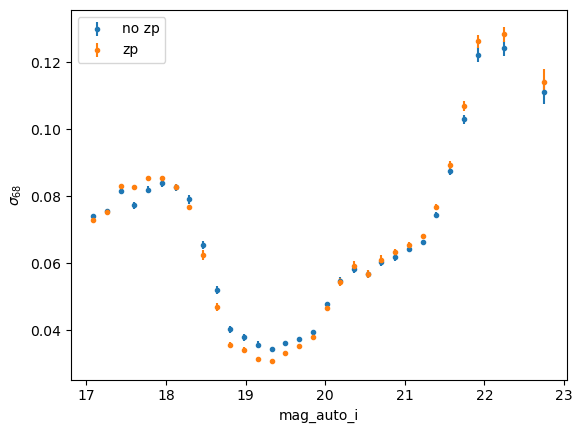

In [17]:
plt.xlabel('mag_auto_i')
plt.ylabel(r'$\sigma_{68}$')
plt.errorbar(magbinsc, sg68_boots_mean, yerr=sg68_boots_std, fmt='.', label='no zp')
plt.errorbar(magbinsc, sg68_boots_mean_zp, yerr=sg68_boots_std_zp, fmt='.', label='zp')
plt.legend()
plt.show()

(array([3.7408e+04, 8.3913e+04, 4.6539e+04, 2.7131e+04, 2.9346e+04,
        2.9474e+04, 4.2106e+04, 6.2257e+04, 4.9341e+04, 2.9220e+04,
        2.1613e+04, 2.1425e+04, 1.7766e+04, 1.1229e+04, 6.3500e+03,
        3.1630e+03, 2.0310e+03, 1.3290e+03, 8.1800e+02, 4.7300e+02,
        2.6200e+02, 2.5200e+02, 1.4300e+02, 1.6000e+02, 8.0000e+01,
        4.8000e+01, 4.1000e+01, 1.9000e+01, 3.4000e+01]),
 array([0.        , 0.06896552, 0.13793103, 0.20689655, 0.27586207,
        0.34482759, 0.4137931 , 0.48275862, 0.55172414, 0.62068966,
        0.68965517, 0.75862069, 0.82758621, 0.89655172, 0.96551724,
        1.03448276, 1.10344828, 1.17241379, 1.24137931, 1.31034483,
        1.37931034, 1.44827586, 1.51724138, 1.5862069 , 1.65517241,
        1.72413793, 1.79310345, 1.86206897, 1.93103448, 2.        ]),
 <BarContainer object of 29 artists>)

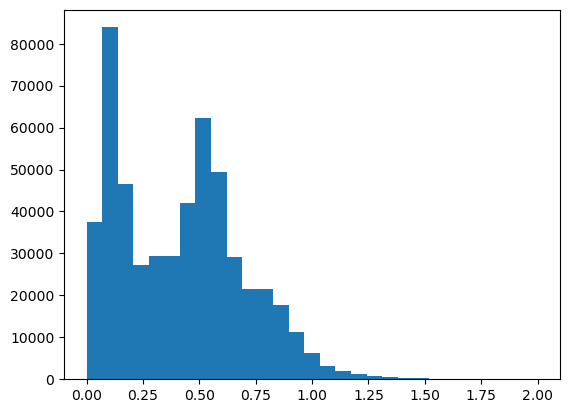

In [18]:
plt.hist(specz, bins=np.linspace(0,2,30))

(array([35864., 27323., 16041., 18208., 21795., 22525., 19870., 22649.,
        40297., 54312., 36106., 11880.,  9244., 11425., 17104., 23449.,
        22694., 14708.,  6932.,  3543.,  1559.,   883.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.]),
 array([17.        , 17.27586207, 17.55172414, 17.82758621, 18.10344828,
        18.37931034, 18.65517241, 18.93103448, 19.20689655, 19.48275862,
        19.75862069, 20.03448276, 20.31034483, 20.5862069 , 20.86206897,
        21.13793103, 21.4137931 , 21.68965517, 21.96551724, 22.24137931,
        22.51724138, 22.79310345, 23.06896552, 23.34482759, 23.62068966,
        23.89655172, 24.17241379, 24.44827586, 24.72413793, 25.        ]),
 <BarContainer object of 29 artists>)

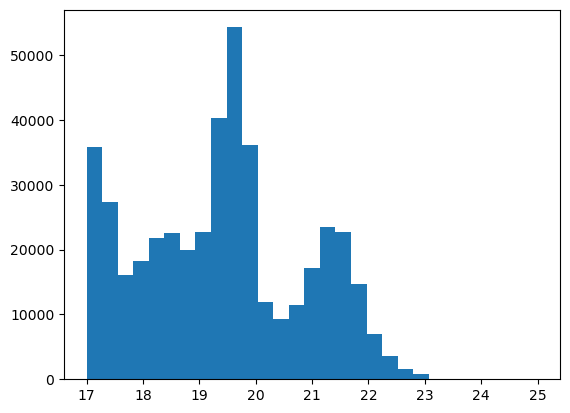

In [19]:
plt.hist(mags, bins=np.linspace(17,25,30))